In [1]:
! pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 3.7 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import visualkeras
import tensorflow as tf
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import random
from random import randint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

# Exploratory Data 


In [3]:
len(os.listdir('../input/histopathologic-cancer-detection/train'))

220025

In [4]:
len(os.listdir('../input/histopathologic-cancer-detection/test'))

57458

In [5]:
df=pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
df.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

41160    1
Name: label, dtype: int64


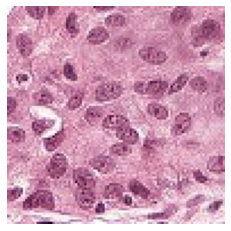

In [7]:
im = Image.open('../input/histopathologic-cancer-detection/train/' + os.listdir('../input/histopathologic-cancer-detection/train')[0])
plt.imshow(im)
plt.axis('off')
print(df[df.id==os.listdir('../input/histopathologic-cancer-detection/train')[0].split('.')[0]].label)

In [8]:
Labels = df.label.values

In [9]:
def get_indexes(label,list_n):
    for x in range(len(Labels)):
        if Labels[x]==label:
            list_n.append(x)
    return list_n

In [10]:
def get_classlabel(class_code):
    labels = {0:'Non-cancerous', 1:'Cancerous'}
    
    return labels[class_code]

In [11]:
no_cancer=[]
no_cancer=get_indexes(0,no_cancer)
cancer=[]
cancer=get_indexes(1,cancer)

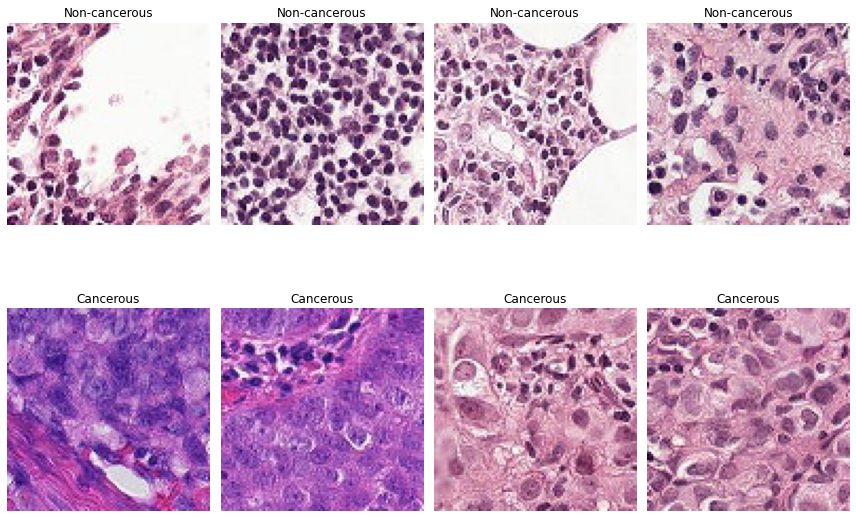

In [12]:
f,ax = plt.subplots(2,4, figsize=(12,12)) 
types_img=[no_cancer, cancer]

for z in range(0,2,1):
    for j in range(0,4,1):
        rnd_number=random.choice(types_img[z])
        ax[z,j].imshow(Image.open('../input/histopathologic-cancer-detection/train/'+df.iloc[rnd_number,0]+'.tif'))
        ax[z,j].set_title(get_classlabel(z))
        ax[z,j].axis('off')
        plt.tight_layout()

Text(0.5, 1.0, 'Black Image')

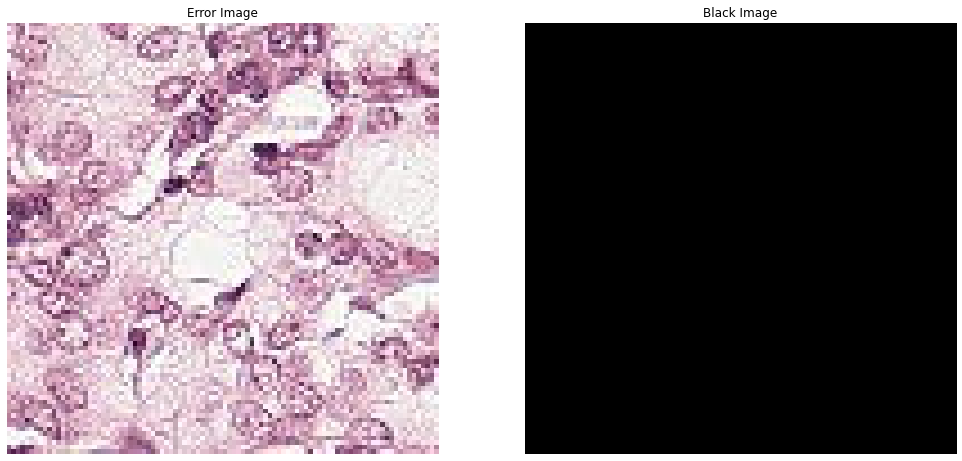

In [13]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(17,17))

ax1.imshow(Image.open('../input/histopathologic-cancer-detection/train/'+'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2.tif'))
ax1.axis('off')
ax1.set_title('Error Image')

ax2.imshow(Image.open('../input/histopathologic-cancer-detection/train/'+'9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif'))
ax2.axis('off')
ax2.set_title('Black Image')

In [14]:
# removing this image because it caused a training error previously
df = df[df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df = df[df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(df.shape)

(220023, 2)


In [15]:
SAMPLE_SIZE=89000

df_0 = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state = 42)
df_1 = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state = 42)

In [16]:
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_data = shuffle(df_data)

df_data['label'].value_counts()

0    89000
1    89000
Name: label, dtype: int64

In [17]:
df_data.head()

,id,label
10478,729e442a843f225f03bb7a54f3d8fa746fb78526,0
21396,f541ba7ad6fdd5a1838564c8bf5089662428ae0d,0
161009,a570e382a7da9ca853dcaa972cc2af63550c5635,1
39253,9eb4fe654782a2ab338b18bb050f06b3cec06a52,0
3702,90ce15724d3752a0385b24ec74d4188028899bc8,0


## Split Data

In [18]:
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=42, stratify=y)

print(df_train.shape)
print(df_val.shape)

(160200, 2)
(17800, 2)


In [19]:
df_train['label'].value_counts(), df_val['label'].value_counts()

(0    80100
 1    80100
 Name: label, dtype: int64,
 0    8900
 1    8900
 Name: label, dtype: int64)

# Create New Directory

In [20]:
base_dir = 'base_dir'
os.mkdir(base_dir)


train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)


val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

non_cancerous_tissue = os.path.join(train_dir, 'non_cancerous_tissue')
os.mkdir(non_cancerous_tissue)
cancerous_tissue = os.path.join(train_dir, 'cancerous_tissue')
os.mkdir(cancerous_tissue)

non_cancerous_tissue = os.path.join(val_dir, 'non_cancerous_tissue')
os.mkdir(non_cancerous_tissue)
cancerous_tissue = os.path.join(val_dir, 'cancerous_tissue')
os.mkdir(cancerous_tissue)

In [21]:
df_data.set_index('id', inplace=True)

## copy the images to their respective directories

In [22]:
train_list = list(df_train['id'])
val_list = list(df_val['id'])

for image in train_list:
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    
    if target == 0:
        label = 'non_cancerous_tissue'
    if target == 1:
        label = 'cancerous_tissue'
    
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    dst = os.path.join(train_dir, label, fname)
    shutil.copyfile(src, dst)


for image in val_list:
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    
    if target == 0:
        label = 'non_cancerous_tissue'
    if target == 1:
        label = 'cancerous_tissue'
    
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    dst = os.path.join(val_dir, label, fname)
    shutil.copyfile(src, dst)

In [23]:
print(len(os.listdir('base_dir/train_dir/non_cancerous_tissue')))
print(len(os.listdir('base_dir/train_dir/cancerous_tissue')))

80100
80100


In [24]:
print(len(os.listdir('base_dir/val_dir/non_cancerous_tissue')))
print(len(os.listdir('base_dir/val_dir/cancerous_tissue')))

8900
8900


In [25]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# Image Data Generator

In [26]:
IMAGE_SIZE=96
datagen = ImageDataGenerator(rescale=1.0/255,
                             featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             zoom_range = 0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary',
                                        shuffle=True)

val_gen = datagen.flow_from_directory(valid_path,
                                      target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                      batch_size=val_batch_size,
                                      class_mode='binary',
                                      shuffle=True)

# Note: shuffle=False causes the test dataset to not be shuffled
val2_gen = datagen.flow_from_directory(valid_path,
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       batch_size=1,
                                       class_mode='binary',
                                       shuffle=False)

Found 160200 images belonging to 2 classes.
Found 17800 images belonging to 2 classes.
Found 17800 images belonging to 2 classes.


# Model

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


#Will stop the training once it reaches 99% validation accuracy:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True
        
callbacks = MyCallback()

#Will reduce the learning rate is validation accuracy didn't improve in one epoch:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=1, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.000001)

#Will save the very best model according to validation accuracy:
model_dir = 'CNN_model_histo.h5'
checkpoint = ModelCheckpoint(model_dir, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

In [28]:
optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

model=Sequential()
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

2022-08-12 00:00:21.294562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 00:00:21.405493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 00:00:21.406327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 00:00:21.410336: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

In [30]:
history = model.fit_generator(train_gen, validation_data=val_gen,
                              epochs=20, verbose=1,
                              callbacks=[callbacks, lr_reduction, checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-12 00:00:24.869547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-08-12 00:00:26.784488: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5007/5007 [==============================] - 630s 124ms/step - loss: 0.4238 - accuracy: 0.8294 - val_loss: 0.4279 - val_accuracy: 0.8192

Epoch 00001: val_accuracy improved from -inf to 0.81921, saving model to CNN_model_histo.h5


2022-08-12 00:10:55.055139: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
2022-08-12 00:10:55.136260: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
2022-08-12 00:10:55.195589: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.


Epoch 2/20
5007/5007 [==============================] - 573s 114ms/step - loss: 0.2840 - accuracy: 0.8878 - val_loss: 0.3672 - val_accuracy: 0.8497

Epoch 00002: val_accuracy improved from 0.81921 to 0.84966, saving model to CNN_model_histo.h5


2022-08-12 00:21:20.880227: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
2022-08-12 00:21:20.928650: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.


Epoch 3/20
5007/5007 [==============================] - 537s 107ms/step - loss: 0.2446 - accuracy: 0.9064 - val_loss: 0.3432 - val_accuracy: 0.8581

Epoch 00003: val_accuracy improved from 0.84966 to 0.85815, saving model to CNN_model_histo.h5
Epoch 4/20
5007/5007 [==============================] - 541s 108ms/step - loss: 0.2232 - accuracy: 0.9157 - val_loss: 0.8427 - val_accuracy: 0.7398

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_accuracy did not improve from 0.85815
Epoch 5/20
5007/5007 [==============================] - 538s 108ms/step - loss: 0.1918 - accuracy: 0.9277 - val_loss: 0.2713 - val_accuracy: 0.8890

Epoch 00005: val_accuracy improved from 0.85815 to 0.88899, saving model to CNN_model_histo.h5
Epoch 6/20
5007/5007 [==============================] - 548s 109ms/step - loss: 0.1833 - accuracy: 0.9312 - val_loss: 0.2667 - val_accuracy: 0.8999

Epoch 00006: val_accuracy improved from 0.88899 to 0.89994, saving model to CN

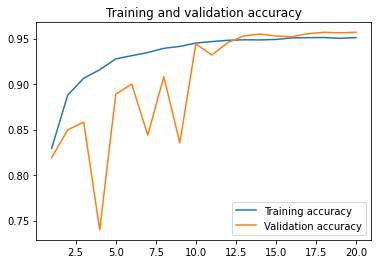

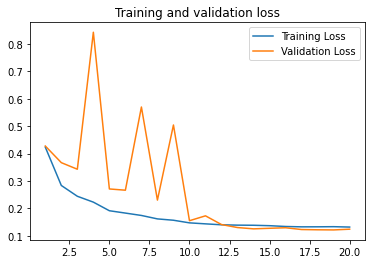

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1,1)

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,0.423784,0.829444,0.427854,0.819214,0.001000
1,0.283972,0.887803,0.367169,0.849663,0.001000
2,0.244615,0.906423,0.343178,0.858146,0.001000
3,0.223187,0.915743,0.842691,0.739831,0.001000
4,0.191843,0.927684,0.271260,0.888989,0.000500
5,0.183294,0.931186,0.266707,0.899944,0.000500
6,0.174617,0.934632,0.570067,0.843820,0.000500
7,0.162080,0.939245,0.230621,0.908090,0.000250
8,0.157173,0.941348,0.504511,0.835562,0.000250
9,0.147630,0.945025,0.155459,0.944101,0.000125


In [33]:
model_saved = load_model('./CNN_model_histo.h5')
model_saved.evaluate_generator(val2_gen, steps=len(df_val), verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


17800/17800 [==============================] - 94s 5ms/step - loss: 0.1209 - accuracy: 0.9567


[0.12088265269994736, 0.9567415714263916]

In [34]:
predicted_val_prob = model_saved.predict_generator(val2_gen, 
                                                   steps=len(df_val), 
                                                   verbose=1)
Y_val_pred= np.round(predicted_val_prob)
Y_val_pred

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


17800/17800 [==============================] - 77s 4ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [35]:
y_true = val2_gen.classes
report = classification_report(y_true, Y_val_pred)

print(report)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      8900
           1       0.95      0.97      0.96      8900

    accuracy                           0.96     17800
   macro avg       0.96      0.96      0.96     17800
weighted avg       0.96      0.96      0.96     17800



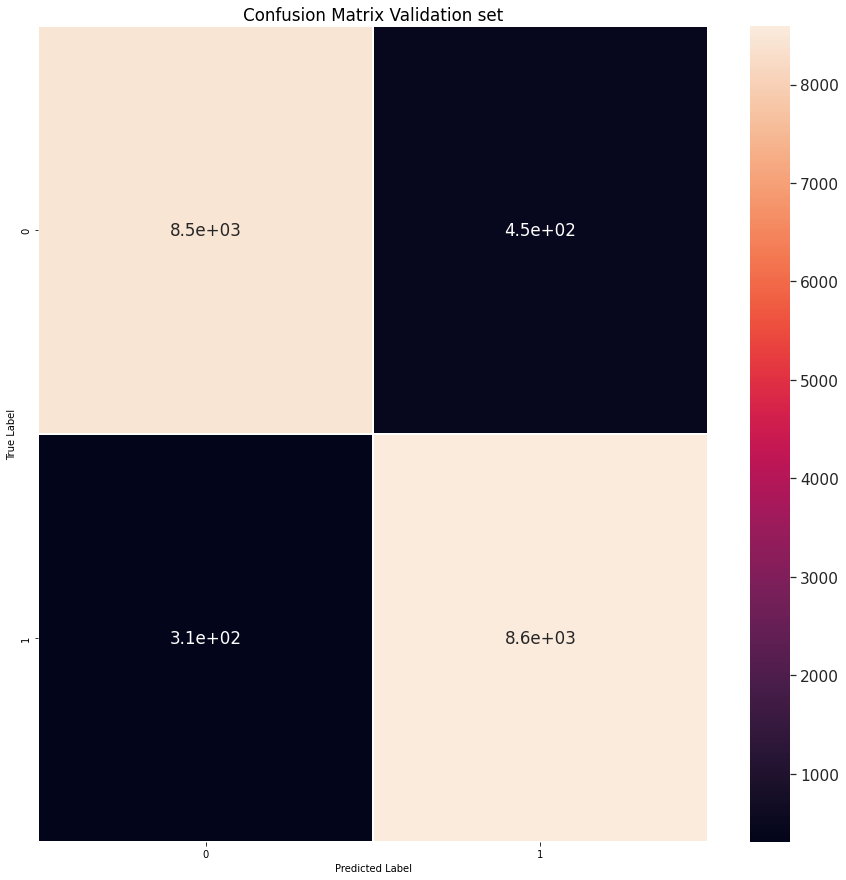

In [36]:
f,ax = plt.subplots(figsize=(15, 15))
confusion_mtx = confusion_matrix(y_true, Y_val_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

In [37]:
metrics = []

precision, recall, fscore, _ = score(y_true, Y_val_pred, average='weighted')
accuracy = accuracy_score(y_true, Y_val_pred)
auc = roc_auc_score(y_true, Y_val_pred)
metrics.append(pd.Series({'precision':precision, 'recall':recall,
                          'fscore':fscore, 'accuracy':accuracy,
                          'auc':auc}, name='CNN model'))
    
metrics = pd.concat(metrics, axis=1)

In [38]:
metrics

,CNN model
precision,0.957471
recall,0.957360
fscore,0.957357
accuracy,0.957360
auc,0.957360


In [39]:
os.listdir('../input/histopathologic-cancer-detection/test')[:5]

['a7ea26360815d8492433b14cd8318607bcf99d9e.tif',
 '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif',
 '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif',
 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif',
 '523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif']

In [40]:
# create test_dir
test_dir = 'test_set_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [41]:
test_list = os.listdir('../input/histopathologic-cancer-detection/test')

for image in test_list:
    fname = image
    src = os.path.join('../input/histopathologic-cancer-detection/test', fname)
    dst = os.path.join(test_images, fname)
    shutil.copyfile(src, dst)

In [42]:
len(os.listdir('test_set_dir/test_images'))

57458

In [43]:
test_path = 'test_set_dir'
test_gen = datagen.flow_from_directory(test_path,
                                       target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                       batch_size=1,
                                       class_mode='categorical',
                                       shuffle=False)

Found 57458 images belonging to 1 classes.


In [44]:
test_predictions = model_saved.predict_generator(test_gen, 
                                                 steps=len(os.listdir('test_set_dir/test_images')), 
                                                 verbose=1)

   13/57458 [..............................] - ETA: 4:08   

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


57458/57458 [==============================] - 285s 5ms/step


In [45]:
non_cancerous = 1 - test_predictions

In [46]:
submission=pd.DataFrame(non_cancerous, columns=['label'])
submission['id']=test_gen.filenames
submission['id']=submission['id'].str.split('/', 
                                            n=1, 
                                            expand=True)[1].str.split('.', 
                                                                      n=1, 
                                                                      expand=True)[0] 
submission.set_index('id', inplace=True)
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.999988
0000ec92553fda4ce39889f9226ace43cae3364e,0.695673
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.988168
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.012258
000270442cc15af719583a8172c87cd2bd9c7746,0.006557


In [47]:
submission.to_csv('submission.csv')